## Research Assistant

### Goal
Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

Source Selection

- Users can choose any set of input sources for their research.

Planning

- Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
- Human-in-the-loop will be used to refine these sub-topics before research begins.

LLM Utilization

- Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
- The interview will be a multi-turn conversation to extract detailed insights as shown in the STORM paper.
- These interviews will be captured in a using sub-graphs with their internal state.

Research Process

- Experts will gather information to answer analyst questions in parallel.
- And all interviews will be conducted simultaneously through map-reduce.

Output Format

- The gathered insights from each interview will be synthesized into a final report.
- We'll use customizable prompts for the report, allowing for a flexible output format.

### 1. Setup the environment

In [1]:
# connect with gemini api
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [11]:
from langfuse.callback import CallbackHandler

# make a simple trace to the langfuse
langfuse_handler = CallbackHandler(
    secret_key="sk-lf-b810fab9-0dc8-4675-a77c-fe3c9bf80bfc",
    public_key="pk-lf-a2d11315-f91c-44ba-a414-d8f335196820",
    host="https://cloud.langfuse.com"
    # host="https://us.cloud.langfuse.com", # 🇺🇸 US region
)
 
# Your Langchain code 
# Add Langfuse handler as callback (classic and LCEL)
llm.invoke( "What is name", config={"callbacks": [langfuse_handler]})

AIMessage(content="As a large language model, I don't have a name. You can just call me Bard.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--e10070b6-9fdb-4bbf-a400-1e00b3ac80fe-0', usage_metadata={'input_tokens': 3, 'output_tokens': 22, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}})

### 2. Generate team of sub agents

AI analysts, each focusing on one sub-topic.

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# class to get structured analyst from the llm
class Analyst(BaseModel):
    # the state or relation of being closely associated or affiliated with a particular Analyst.
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
        )
    # name of the analyst
    name: str = Field(
        description="name of the analyst"
    )
    # role of the analyst in terms of topic
    role: str = Field(
        description="Description of the analyst focus, concerns, and motives."
    ) 
    # this method is callable like a property but behind is a function 
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

# this class is to get list of Analysts form llm model  
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

# then make the internal state of the subgraph generate analysts
class GenerateAnalystsState(TypedDict):
    topic: str # reseach topic
    max_analysts: int # maximum number of analysts
    human_analyst_feedback: str # any human feedback to llm
    analysts: List[Analyst] # generated analysts

# Requirment analysis agent
Get requirment from the client and make questions and make a report about the requirement

## 1. Get user need as message and generate sub-parts to explore more

This sub graph generate sub headings from the user need.

These generated sub heading leater used for more clrarifications of user requirements.

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

class GeneratedSubHeading(BaseModel):
    generated_sub_heading: str = Field(None, description="generated sub part for understand the user need.")

# sub graph state
class SubHeadingState(MessagesState):
    max_generated_sub_headings: int # Number of generated queries
    generated_sub_headings: List[GeneratedSubHeading] # Generated questions

class Perspectives(BaseModel):
    sub_headings: List[GeneratedSubHeading] = Field(
        description="Comprehensive list of sub part headings that align with user need.",
    )


In [31]:
generate_sub_headings_instructions = """You are an caller agent user call for specific need.
                                 
                                 So you need do identify sub parts of the user need and generate sub part headings for get good understand about user need.

                                 You need to generate maximum {max_sub_parts} sub parts to get clear understand about user need.
                                 
                                 """

In [32]:
# test for question generation.
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# Make the system message
system_message = generate_sub_headings_instructions.format(max_sub_parts=5)

# Enforce structured output
structured_llm = llm.with_structured_output(Perspectives)

# Generate question 
queries = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+ [HumanMessage(content="I want to build a website")])

In [33]:
print(queries.sub_headings)

[GeneratedSubHeading(generated_sub_heading='Purpose of the website'), GeneratedSubHeading(generated_sub_heading='Target audience'), GeneratedSubHeading(generated_sub_heading='Key features'), GeneratedSubHeading(generated_sub_heading='Content strategy'), GeneratedSubHeading(generated_sub_heading='Technical requirements')]


In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def generate_sub_headings(state: SubHeadingState):
    # define the variables
    max_sub_headings=state["max_generated_sub_headings"]

    # get the history of the messages
    messages = state.get('messages', [])
    if not messages:
        raise ValueError("The 'messages' list is empty. Cannot generate subheadings without a conversation history.")

    # get the last message
    message = messages[-1]


    # get the structed output
    system_message = generate_sub_headings_instructions.format(max_sub_parts=max_sub_headings)

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # Generate question 
    subheadings = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+[message])
    
    # update the state
    return {"generated_sub_headings": subheadings}

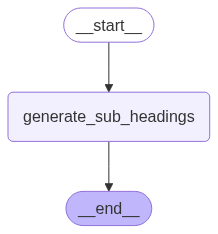

In [50]:
# make a subgraph to generate subheading based on the user need
GenerateSubHeadingBuilder = StateGraph(SubHeadingState)
GenerateSubHeadingBuilder.add_node("generate_sub_headings", generate_sub_headings)

# make connections
GenerateSubHeadingBuilder.add_edge(START,"generate_sub_headings")
GenerateSubHeadingBuilder.add_edge("generate_sub_headings",END)

# compile
memory = MemorySaver()
graph = GenerateSubHeadingBuilder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# sample graph invoke
thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": [HumanMessage(content="I want to build a mobile app")], "max_generated_sub_headings": 10}, thread)

{'messages': [HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='5decbfe6-0788-4a81-a852-23a41bd84988'),
  HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='15ff0fa4-0ca9-48bb-97cf-1b1f66a9a338'),
  HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='55b2969b-6f88-4370-a1a5-46bdf94bc4a7'),
  HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='cdf39020-1ec1-4977-b3b5-ed3dab1336bd')],
 'max_generated_sub_headings': 10,
 'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'

## 2. Make sub headings as topics make a conversation with user.

This sub graph use the generated sub headings to explore more about this topic with the customer.

In [ ]:
last_state = {'messages': [HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='5decbfe6-0788-4a81-a852-23a41bd84988'),
            HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='15ff0fa4-0ca9-48bb-97cf-1b1f66a9a338'),
            HumanMessage(content='I want to build a website', additional_kwargs={}, response_metadata={}, id='55b2969b-6f88-4370-a1a5-46bdf94bc4a7'),
            HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='cdf39020-1ec1-4977-b3b5-ed3dab1336bd')],
            'max_generated_sub_headings': 10,
            'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}

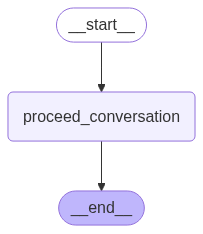

In [ ]:
def proceed_conversation(state: SubHeadingState):
    # get the current sub heading one by one
    sub_headings = state.pop('generated_sub_headings', [])

    # if there is no remaining subheading go to the next sub graph to generate report
    if not sub_headings:
        ValueError("all subheadings are finished.")

    sub_headings.sub_headings = sub_headings.sub_headings[1:]
    
    return {'generated_sub_headings':sub_headings}

# make a subgraph to generate subheading based on the user need
GenerateSubHeadingBuilder = StateGraph(SubHeadingState)
GenerateSubHeadingBuilder.add_node("proceed_conversation", proceed_conversation)

# make connections
GenerateSubHeadingBuilder.add_edge(START,"proceed_conversation")
GenerateSubHeadingBuilder.add_edge("proceed_conversation",END)

# compile
memory = MemorySaver()
graph = GenerateSubHeadingBuilder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
# sample graph invoke
thread = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages": [HumanMessage(content="I want to build a mobile app")], "max_generated_sub_headings": 10,'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='App Functionality'), GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}, thread)

{'messages': [HumanMessage(content='I want to build a mobile app', additional_kwargs={}, response_metadata={}, id='5b7f7e08-0b5b-4ebb-aabc-ef9ab766a1ac')],
 'max_generated_sub_headings': 10,
 'generated_sub_headings': Perspectives(sub_headings=[GeneratedSubHeading(generated_sub_heading='Target Audience'), GeneratedSubHeading(generated_sub_heading='Platform (iOS, Android, or both)'), GeneratedSubHeading(generated_sub_heading='Development Budget'), GeneratedSubHeading(generated_sub_heading='Monetization Strategy'), GeneratedSubHeading(generated_sub_heading='Timeline for Development'), GeneratedSubHeading(generated_sub_heading='Required Features'), GeneratedSubHeading(generated_sub_heading='Design Preferences'), GeneratedSubHeading(generated_sub_heading='Marketing Plan'), GeneratedSubHeading(generated_sub_heading='Maintenance and Updates')])}

### Unit Testing for notebook

This ensure the written functions are giving correct outputs

In [11]:
import unittest
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class TestFunctions(unittest.TestCase):

    def test_generated_sub_heading_type(self):
        
        # generate sub heading based on input 
        generate_query_instructions = """You are an caller agent user call for specific need.
                                 
                                 So you need do identify sub parts of the user need and generate sub part headings for get good understand about user need.

                                 You need to generate maximum {max_sub_parts} sub parts to get clear understand about user need.
                                 
                                 """
        
        # Make the system message
        system_message = generate_query_instructions.format(max_sub_parts=5)

        # Enforce structured output
        structured_llm = llm.with_structured_output(Perspectives)

        # Generate question 
        queries = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate sub part headings.")]+ [HumanMessage(content="I want to build a website")])

        # check for the type
        self.assertIsInstance(queries.sub_headings,list)
        for item in queries.sub_headings:
            self.assertIsInstance(item, GeneratedSubHeading)


# run the unit tests
if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)


test_generated_sub_heading_type (__main__.TestFunctions.test_generated_sub_heading_type) ... ok

----------------------------------------------------------------------
Ran 1 test in 1.140s

OK
